# Spiking Neural Networks and Adversarial Attacks

This notebook will present the third generation of neural networks : Spiking Neural Networks (SNNs) and one of their particularity, their robustness against adversarial Attacks. We will study it on the MNIST dataset, so SNNs will be used for image classification.

The notebook will be divided into 3 parts : 

1. [Spiking Neural Networks](#example)
2. [Adversarial Attacks](#example2)
3. [Robustness of SNNs against adversarial attacks compared to CNNs](#third-example)

## Spiking Neural Networks

Spiking Neural Networks are a new generation of Artificial Neural Networks. Their aim is to be closer to brain's functionning and bridge the gap between neuro-science and machine learning. SNNs introduce a new dimension : time. A neuron cannot be activated all the time anymore. To transmit information a threshold has to be reached, then the neuron can transmit the information, and it will not be able to transmit any information in a little amont of time : refractory period. The input of the network will not be continuous values anymore but spikes, events which occure at points in time.

![Image1](Image1.png)

Here is the representation of Spiking neuron (b) compared to usual neuron (a). The spiking neuron takes as an input, series of spikes which are 0 and 1's, and when the threshold $U_{th}$ is reached, a spike is produced as an ouptut.

#### Exercice 1

Let's take an example. 
We will deal with a spiking neuron, with a voltage $U^{t}, t \in \mathbb{N}$ taking $U_{1}$ and $U_{2}$ as inputs. At each time, the output is written $s_t$ with $s_t=1$ if a spike is produced and $0$ otherwise.

Here are pieces of information :
- At each time $t$ the neuron's voltage will win $U_1 \omega_{1} + U_2 \omega_{2}$ Volts.
- If the neuron is activated at time $t$, ie $U^{t} >0$, it will loose $U_{-}$ Volts at time $t+1$. 
- The neuron's voltage cannot be negative
- A spike is produced at time $t$ if $U_t > U^{th}$
- If a spike is produced, the neuron is instantly, and keep spleeping for the next 3 periods (refractory period).

Write $U^{t+1}$ as a function of $U_1, U_2,\omega_1,\omega_2, U_{\tau}, s_{\tau}, \tau<t+1$.

Write $S_{t}$ as a function of $U_1, U_2,\omega_1,\omega_2, U_{\tau}, s_{\tau}, \tau<t+1$.

Tip : you're allowed to use ifs.

$$
U_{t+1} = \left\{
    \begin{array}{ll}
        max(0,U_t + U_1 \omega_1 + U_2 \omega_2 - U_{-}) & if & \left\{
            \begin{array}{ll}
            U_t + U_1 \omega_1 + U_2 \omega_2 - U_{-}<U_th \\
            s_{t-3} + s_{t-2} + s_{t-1} + s_{t} = 0
            \end{array}
        \right. \\
        0 & else.
    \end{array}
\right.
\newline
S_{t} = \left\{
    \begin{array}{ll}
        1 & if & U_t + U_1 \omega_1 + U_2 \omega_2 - U_{-} > U_th \\
        0 & else.
    \end{array}
\right.

$$

Now that we have our mathematic expression of a spiking neuron, we will compute it.


### Exercice 2

Let's say that we have periods of 1 ms. Given the 2 iputs of spikes $U_{1}$ and $U_{2}$, compute and plot $U_t$ and $S_{t}$. 

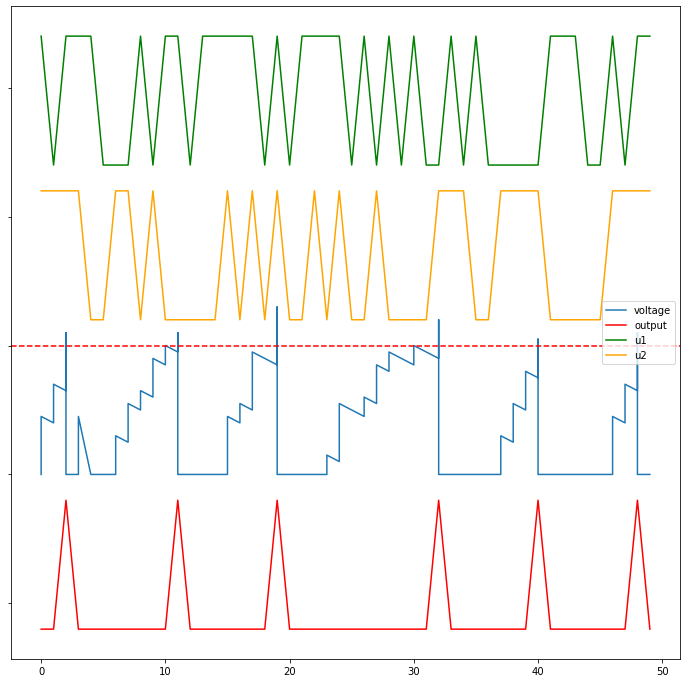

In [23]:
# Write your code here.
import numpy as np
import matplotlib.pyplot as plt
import random

U1=[random.randint(0,1) for i in range(50)]
U2=[random.randint(0,1) for i in range(50)]

w1= 0.15
w2=0.3
Uth=1
Umoins=0.05

U=[0,U1[0]*w1+U2[0]*w2]
T=[0,0]
S=[0]
for i in range(1,len(U1)):
    if len(S)<4 or np.sum(S[-3:])==0:
        voltage=np.max([U[-1]-Umoins,0])
        U.append(voltage)
        T.append(i)
        voltage=voltage+U1[i]*w1+U2[i]*w2
        U.append(voltage)
        T.append(i)
        if voltage>=Uth:
            U.append(0)
            T.append(i)
            S.append(1)
        else:
            S.append(0)
    else:
        U.append(0)
        T.append(i)
        S.append(0)

fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(1,1,1)
plt.plot(T,U,label='voltage')
plt.plot([i for i in range(50)],np.array(S)-1.2,color='red',label='output')
plt.plot([i for i in range(50)],np.array(U1)+2.4,color='green',label='u1')
plt.plot([i for i in range(50)],np.array(U2)+1.2,color='orange',label='u2')
ax.set_yticklabels([])
plt.legend()
plt.axhline(1,linestyle='--',color='r')
    


As we can see on the plot, when the voltage reaches the threshold, a spike is produces and the voltage is reset at 0 for 3ms : this is the refractory period. It is inspired by the chemical mecanisms between neurons. This is because the sodium channels embedded in the cell membrane cause the spike generation event by opening.

This was a simplified spiking neuron. Here is a representation of Leaky integrate-and-fire (LIF) spiking neuron. It follows a differential equation which leads to exponential decrease.

![Image2](Image2.png)

So now, as we will use SNNs for image classification, the main question is : how do we transform images to series of spikes ?

Fortunatly for us, it is quite simple. After the threshold and the refractory period, let me introduce a new hyperparameters of SNNs, the sequence length. Let's say you're looking at an image, the sequence length will be the amount of time you're looking at the image.

Let's take a sequence length of 64. This means we are looking at the image during 64ms. So now we want to transform each pixel which is represented by a number between 0 and 255 in a list of 0 and 1's of length 64. How do you do it ? Please think about this for a few minutes and then uncover the solution.

$\forall k \in \llbracket 0, seq_{length} \llbracket , P(U_{k}=1)=\frac{digit \space value}{255}$

The darker the pixel is, the more spikes (1's) the sequence will contain.
The brigther it is, the more 0's it will contain.

As be can see on the picture below, each images will be converted in seq_length black and white images.

![Image3](Image3.jpg)

The last question is : How do we transform outputs spikes in a label choice for classification.
For MNIST classification we will have 10 outputs, each of them will be series of spikes, of length seq_length. We will simply count how many spikes were received by each label, the winner is the one which received the most.

## Adversarial attacks

DNNs are now deployed in a wide range of sectors, but despite their performance, they don't face well the challenge of adversarial attacks. In fact, many DNNs are very vulnerable to inputs carefully modified by the attacker to fool them.
We will take the strongest example where the attacker knows the full structure and parameters of the DNN. His aim is to fool him by modifying the inputs with the smallest change. He does so by adding noise to the image, the he wants to minimize the injected noise to avoid detection.

Formally, given an original input $x$ with a target label $l$ with a classification model $f()$, the problem of generating an adversarial example $x^*$ can be formulated as a constrained optimization problem, i.e.,

$x^* = arg min \space D(x,x^*), \\
s.t. \space f(x)=l, f(x^*)=l^*, l \neq l^*$ 



In this notebook we will apply a PGD attack (Projectly Gradient Descent) which is the most widely used attack. PGD attack tries to find the perturbation that maximizes the loss of a model on a given sample while keeping the perturbation magnitude lower than a given budget.

## Robustness of SNNs against adversarial attacks compared to CNNs





$$

In [2]:
!pip install norse
!pip install foolbox
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from norse.torch.functional.lif import LIFParameters
from norse.torch.module.leaky_integrator import LILinearCell
from norse.torch.module.lif import LIFCell
import norse.torch.functional.encode as encode
import foolbox as fb
import foolbox.attacks as fa
from foolbox import PyTorchModel, accuracy, samples
from Classes import *

We will test the robustness on the MNIST dataset. 3 models where already trained. A Convolution Neural Networks (Lenet-5) which a classic artificial neural network, and 2 spiking neural networks. Both have the same architecture as Lenet-5 but classic neurons are replaced with spiking neurons : Leaky Integrate and Fire (LIF) neurons. The only difference between the two SNNs are the hyperparameters, one has a 1V threshold with a sequence length of 64ms. The other one has a 1.75 threshold with a sequence length of 48ms. 


### Lenet-5 architecture
![Image4](Image4.png)

Here is the code to load the MNIST test dataset.

In [ ]:
batchsize = 64
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))])
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False)

Here is the code to load the trained models. They were all trained on 1 epoch on the MNIST trainset.

In [ ]:
CNN = torch.load('CNN.pt')
SNN1 = torch.load('SNN_64_1.pt')
SNN2 = torch.load('SNN_48_1-75.pt')

Here is the code to coonduct a PGD attach on the CNN dataset with a given noise budget $\epsilon = 1$.

In [ ]:
eps=1.

adv_loader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False)

examples = enumerate(adv_loader)
batch_idx, (images, labels) = next(examples)
images=images.cuda()
labels=labels.cuda()
fmodelCNN = fb.PyTorchModel(CNN, bounds=(0, 1))
attack = fb.attacks.PGD()
_, advs, success = attack(fmodelCNN, images, labels, epsilons=eps)
robust_accuracy = 1 - success.float().mean(axis=-1)
print('For a noise budget of {} we get an accuracy of {}.'.format( eps, robust_accuracy.item()))

### Exercise

Conduct attacks on the 3 models with different noise budgets in order to compare their robustness to an adversarial attack. A maximum noise budget of 2 can be considered.

NB: a PGD attack with a noise budget of 0 will return the model's accuracy as if it was not attacked.

In [ ]:
#Write your code here.